In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym

In [2]:
tf.enable_eager_execution()

Want to find temporally abstract patterns between observations, actions and rewards.

In [3]:
# env = gym.make('Pong-v0')
env = gym.make('MsPacman-v0')
# env = gym.make('Seaquest-v0')

/home/telfaralex/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(70, 54)


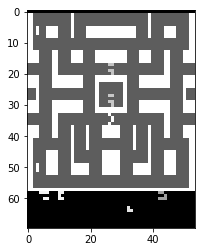

In [4]:
def preprocess(x):
    # down sample and remove color
    return x.sum(axis=-1)[::3, ::3]

obs = preprocess(env.reset())
obs_shape = obs.shape
plt.imshow(obs, cmap='gray')
print(obs_shape)

In [5]:
def play_episode(player, env, len_episode=100):
    obs = env.reset()
    trajectory = []
    old_obs = obs
    done = False
    
    # need fixed length trajectories
    for i in range(len_episode):
        if not done:
            a = player(obs)
            obs, r, done, info = env.step(a)
            
        else:  # pad with zeros
            a = 0
            obs, r, done, info = (np.zeros(old_obs.shape), 0, done, None)

        trajectory.append(np.concatenate([np.array([a]), preprocess(old_obs).ravel(), np.array([r])]))
        old_obs = obs
    return np.vstack(trajectory)

In [6]:
len_episode = 50
n_actions = env.action_space.n
n_possible_trajectories = n_actions**len_episode
print('Total possible trajectories = {}'.format(n_possible_trajectories))

Total possible trajectories = 515377520732011331036461129765621272702107522001


In [7]:
trajectory = play_episode(lambda *args: env.action_space.sample(), env, 1000)

In [8]:
def generate_data(n_episodes, len_episodes):
    # generate dataset using rnd policy
    dataset = np.stack([play_episode(lambda *args: env.action_space.sample(), env, len_episodes)
                          for _ in range(n_episodes)], axis=0)
    return dataset  # N x len x [a, obs, r]

def batch_to_options(dataset, n_actions_in_option):
    # get all combinations of actions to 
    # eval the options we have data for
    
    # in: batch x len x [a, obs, r] 
    # out: traj x option x [a,obs, r]
    B, L, D = dataset.shape
    out = tf.extract_image_patches(
        np.reshape(dataset, [B, 1, L, D]), 
        ksizes=[1,1,n_actions_in_option,1], 
        strides=[1,1,1,1], 
        rates=[1,1,1,1], 
        padding="SAME").numpy()
    out = np.reshape(out, [B*L, n_actions_in_option, D])
    return out


In [9]:
len_option = 3

In [10]:
dataset = generate_data(100, 500)
dataset.shape

(100, 500, 3782)

In [11]:
actions = batch_to_options(dataset[:,:-1,0:1], len_option)
actions = tf.constant(actions, dtype=tf.int32)
actions = tf.one_hot(actions, axis=-1, depth=env.action_space.n, off_value=0.0,on_value=1.0)
actions = actions.numpy()
actions = np.reshape(actions, [actions.shape[0], -1])
actions.shape
# convert actions to onehot and stack into last dim

(49900, 27)

In [12]:
obs = batch_to_options(dataset[:,1:,1:-1] - dataset[:,:-1,1:-1], len_option)
obs = np.reshape(obs, [obs.shape[0], -1])
obs.shape

(49900, 11340)

In [13]:
r = batch_to_options(dataset[:,1:,-1:], len_option)
r = np.reshape(r, [r.shape[0], -1])
r.shape

(49900, 3)

In [32]:
# use difference between obs. as actions probs wont correlate with abs values,
# but should correlate which changes in x!?

corr = np.dot((actions-actions.mean(axis=0)).T, (obs-obs.mean(axis=0)))  
corr.shape

(27, 11340)

In [33]:
# corr = np.cov(actions.T, obs.T)
# plt.imshow(np.sqrt(np.abs(corr)), interpolation='nearest', cmap='gray')

In [34]:
u, s, v = np.linalg.svd(corr)
print(u.shape, s.shape, v.shape)

(27, 27) (27,) (11340, 11340)


<BarContainer object of 27 artists>

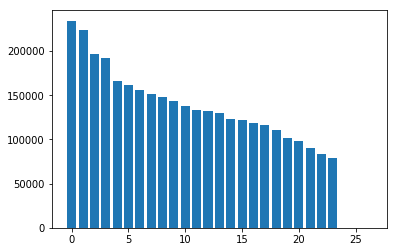

In [35]:
plt.bar(range(len(s)), s)

In [36]:
def get_action_components(i, u, s):
    component_a = s[i] * u[i, :]
    return [np.argmax(np.abs(component_a[j*env.action_space.n:(j+1)*env.action_space.n])) 
            for j in range(len_option)]

def get_obs_components(i, s, v):

    component_obs = s[i] * v[:, i]
    n = np.prod(obs_shape)
    return [np.reshape(component_obs[j*n:(j+1)*n], obs_shape) 
            for j in range(len_option)]

In [37]:
def show_ith_component(i, u, s, v):
    component_obs = get_obs_components(i, s, v)
    # BUG these are visualising differences not images. show add to original!?
    component_as = get_action_components(i, u, s)
    
    plt.figure(figsize=(16, 16))
    for i, obs, a in zip(range(len_option), component_obs, component_as):
        plt.subplot(1, len_option, i+1)
        obs = np.sqrt(np.abs(obs)) ## turn up the contrast
        plt.imshow(obs, cmap='gray')

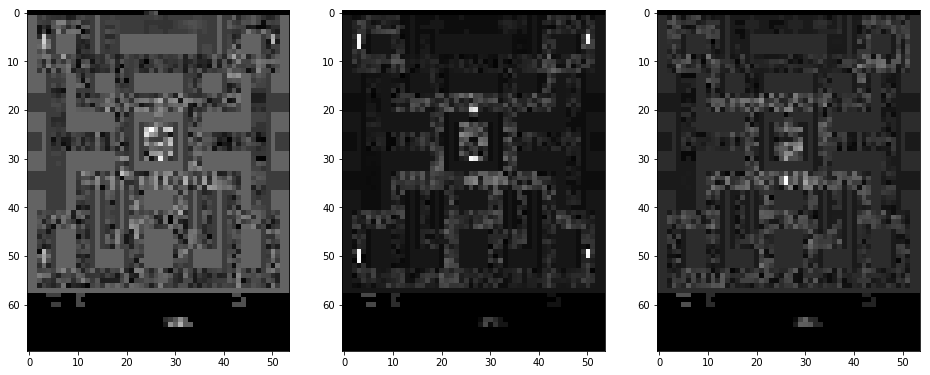

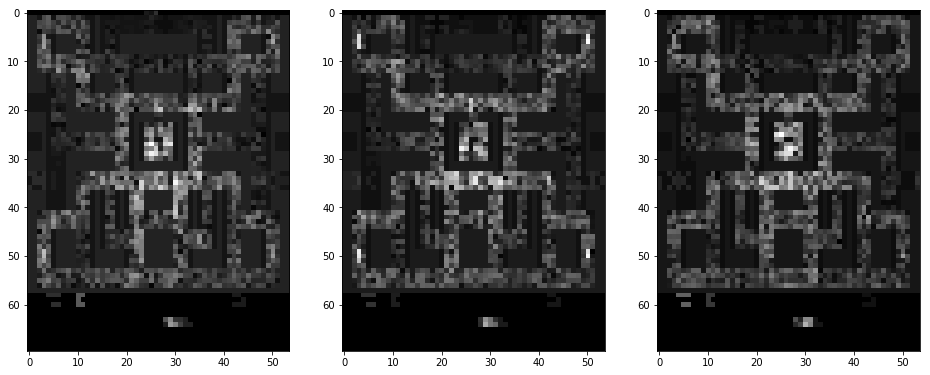

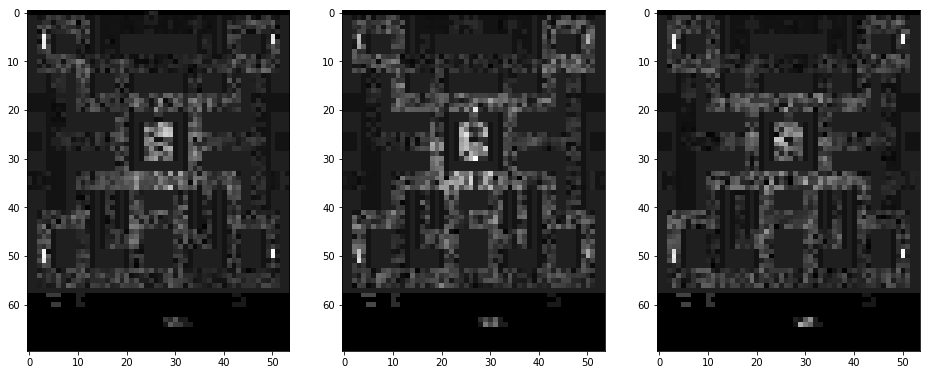

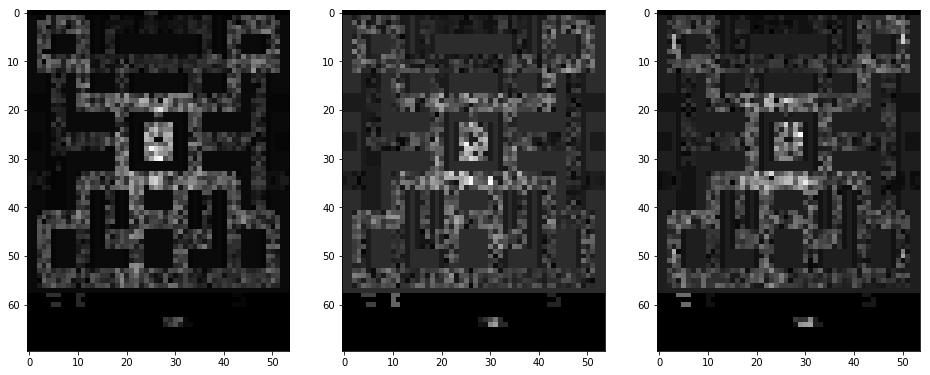

In [38]:
for i in range(4):
    show_ith_component(i, u, s ,v)

In [39]:
# not sure what to make of these...
# these are the options that describe the most variance in the observations (?)
# TODO i guess the next step would be to see how well a RLer does with these options, rather than raw actions!?
options = {}

for i in range(u.shape[0]):
    opt = get_action_components(i, u, s)
    print('{}: {}'.format(i, opt))
    options[i] = opt

0: [0, 1, 8]
1: [5, 3, 1]
2: [3, 8, 8]
3: [4, 7, 4]
4: [5, 8, 0]
5: [7, 3, 2]
6: [4, 5, 5]
7: [7, 6, 8]
8: [4, 3, 3]
9: [6, 0, 6]
10: [3, 4, 0]
11: [0, 0, 1]
12: [5, 7, 4]
13: [5, 1, 5]
14: [3, 1, 2]
15: [5, 7, 4]
16: [5, 0, 0]
17: [4, 1, 3]
18: [2, 0, 7]
19: [8, 4, 1]
20: [1, 7, 0]
21: [8, 5, 4]
22: [7, 2, 1]
23: [0, 4, 2]
24: [1, 8, 7]
25: [4, 4, 0]
26: [6, 5, 3]


In [40]:
corr = np.dot((actions-actions.mean(axis=0)).T, (r-r.mean(axis=0)))
corr.shape

(27, 3)

<BarContainer object of 3 artists>

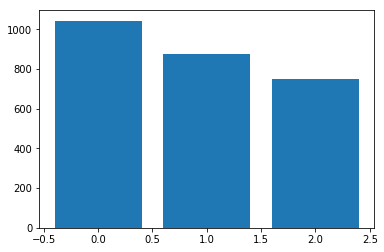

In [41]:
u, s, v = np.linalg.svd(corr)
plt.bar(range(s.size), s)

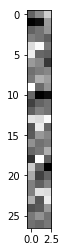

In [42]:
plt.imshow(corr, cmap='gray')

In [44]:
# these are the options that describe the most variance in the rewards
# but we dont really care about the variance in the rewards. we just want 
# to find the options that result in max rewards...

for i in range(len_option):
    opt = get_action_components(i, u, s)
    options[27+i] = opt
    print(opt)

[5, 0, 0]
[4, 1, 0]
[6, 4, 5]


In [45]:
options  
# maybe add some random ones as well!?
# maybe clip the ones that dont explain any variance...!?

{0: [0, 1, 8],
 1: [5, 3, 1],
 2: [3, 8, 8],
 3: [4, 7, 4],
 4: [5, 8, 0],
 5: [7, 3, 2],
 6: [4, 5, 5],
 7: [7, 6, 8],
 8: [4, 3, 3],
 9: [6, 0, 6],
 10: [3, 4, 0],
 11: [0, 0, 1],
 12: [5, 7, 4],
 13: [5, 1, 5],
 14: [3, 1, 2],
 15: [5, 7, 4],
 16: [5, 0, 0],
 17: [4, 1, 3],
 18: [2, 0, 7],
 19: [8, 4, 1],
 20: [1, 7, 0],
 21: [8, 5, 4],
 22: [7, 2, 1],
 23: [0, 4, 2],
 24: [1, 8, 7],
 25: [4, 4, 0],
 26: [6, 5, 3],
 27: [5, 0, 0],
 28: [4, 1, 0],
 29: [6, 4, 5]}

In [ ]:
class SARSA_w_Options():
    # online learning w options
    def __init__(self, options, n_states):
        self.options = options
        self.n_options = len(options)
        
        self.gamma = 0.999
        self.lr = 0.1

        self.qs = np.zeros([n_states, n_options])
        
        self.action_queue = deque()
        self.action_queue.add(*np.random.choice(self.options))
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def __call__(self, s, r):
        if len(self.action_dequeue) == 0:
            opt = sample(np.arange(n_actions), self.qs[s, ...])
            self.action_queue.append(*opt)
        a = self.action_queue.pop(0)
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, r, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
        delta =  target - self.qs[old_s, old_a]
        self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!
        self.qs -= 1e-6 * self.qs  # entropy regularisation

In [ ]:
def play_episode_w_options(player, env, len_episode=100):
    obs = env.reset()
    trajectory = []
    old_obs = obs
    done = False
    
    # need fixed length trajectories
    for i in range(len_episode):
        if not done:
            a = player(obs)
            obs, r, done, info = env.step(a)
            
        else:  # pad with zeros
            a = 0
            obs, r, done, info = (np.zeros(old_obs.shape), 0, done, None)

        trajectory.append(np.concatenate([np.array([a]), preprocess(old_obs).ravel(), np.array([r])]))
        old_obs = obs
    return np.vstack(trajectory)